# **E14. GAN으로 패션 데이터 생성하기**

CIFAR-10의 데이터셋을 활용하여 새 패션 데이터를 생성해보겠습니다.

---

## **00. 모듈 & 데이터셋 생성**

In [1]:
# from google.colab import drive
# drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [40]:
import os
import glob
import time
import cv2

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("Done!")

Done!


In [3]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [4]:
test_x.shape

(10000, 32, 32, 3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


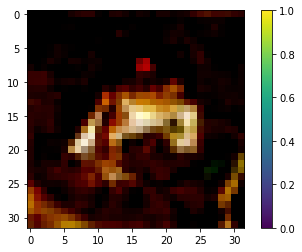

In [8]:
# 시각화
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

...? 무슨 지옥의 그림 같군요....

In [9]:
# 미니배치
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Done!")

Done!


---

## **01. 생성자 구현**

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

print("Done!")

Done!


In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [12]:
# noise 생성
noise = tf.random.normal([1, 100])

print("Done!")

Done!


In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

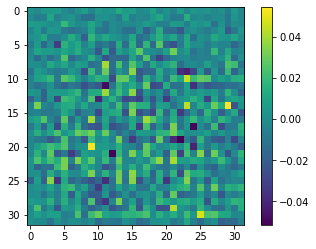

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

---

## **02. 판별자 구현**

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(3))

    return model

print("Done!")

Done!


In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.00365819,  0.00037689, -0.00332339]], dtype=float32)>

---

## **03. 손실함수**

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

print("Done!")

Done!


In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

print("Done!")

Done!


In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

print("Done!")

Done!


In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

print("Done!")

Done!


---

## **04. 최적화 함수**

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

print("Done!")

Done!


In [23]:
# noise 생성
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [73]:
# @tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

print("Done!")

Done!


In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('/content/mydrive/MyDrive/AIFFEL/E14/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

print("Done!")

Done!


In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/mydrive/MyDrive/AIFFEL/E14/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

print("Done!")

Done!


In [27]:
checkpoint_dir = '/content/mydrive/MyDrive/AIFFEL/E14/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

print("Done!")

Done!


---

## **05. 모델 훈련**

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
    
print("Done!")

Done!


In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

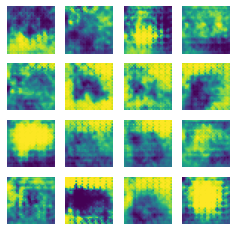

Time for training : 554 sec


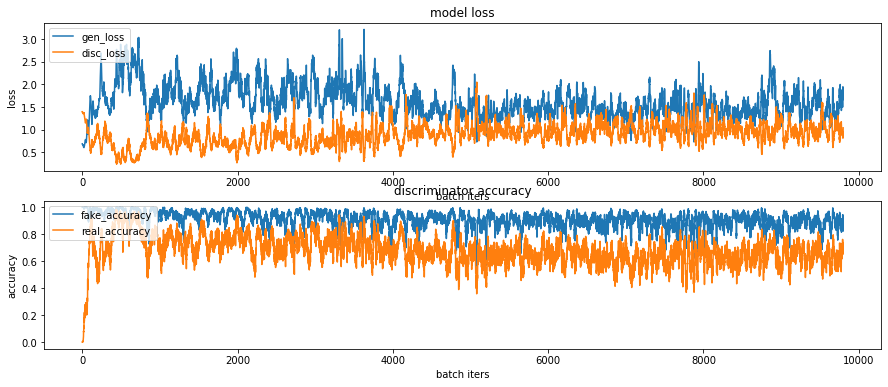

CPU times: user 7min 58s, sys: 10.1 s, total: 8min 8s
Wall time: 9min 16s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

accuracy 값이 조금씩 내려오고는 있지만, 아직 1에 가깝습니다.

epoch를 더 늘려보겠습니다.

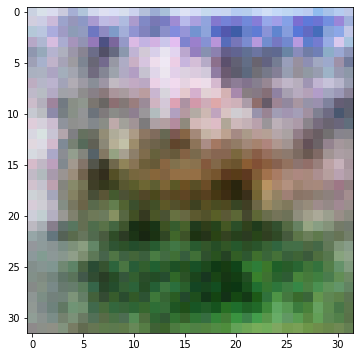

In [31]:
checkpoint_dir = '/content/mydrive/MyDrive/AIFFEL/E14/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

In [32]:
save_every = 5
EPOCHS = 300

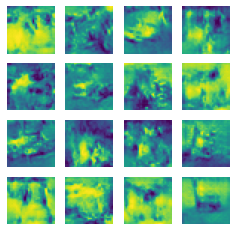

Time for training : 3449 sec


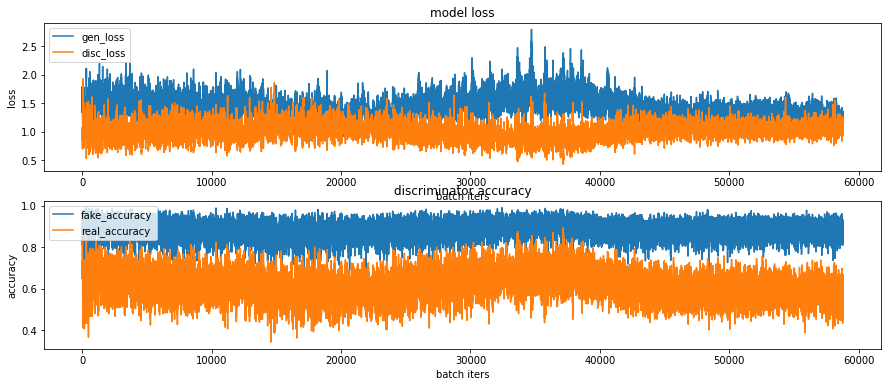

CPU times: user 52min 1s, sys: 45.1 s, total: 52min 46s
Wall time: 57min 33s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

## **06. 시각화**

In [54]:
anim_file = '/content/mydrive/MyDrive/AIFFEL/E14/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/mydrive/MyDrive/AIFFEL/E14/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [53]:
anim_file = '/content/mydrive/MyDrive/AIFFEL/E14/dcgan_history.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/mydrive/MyDrive/AIFFEL/E14/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


![img]('')

---

## **07. GAN 개선하기**

epoch 300 정도로는 실제같은 이미지를 생성하기엔 어림도 없는 것 같습니다.

그렇다면 하이퍼파라미터를 조금 만져봅시다.

In [75]:
# 미니배치
BUFFER_SIZE = 50000

# 배치 사이즈 256->128
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Done!")

Done!


### **07-1. 생성자**

In [76]:
# 생성자
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

print("Done!")

Done!


In [77]:
model = make_generator_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 128)       

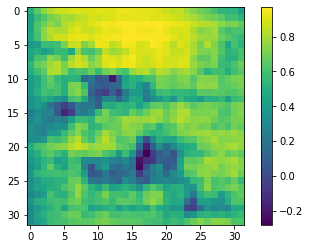

In [78]:
# noise 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### **07-2. 판별자**

In [79]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(3))

    return model

print("Done!")

Done!


In [80]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [81]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.02164912, 0.06552185, 0.06735271]], dtype=float32)>

In [82]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

print("Done!")

Done!


### **07-3. 재훈련**

훈련시켜보겠습니다.

In [83]:
save_every = 5
EPOCHS = 500

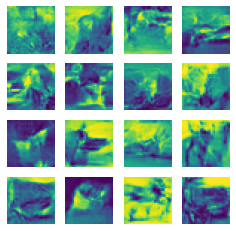

Time for training : 7383 sec


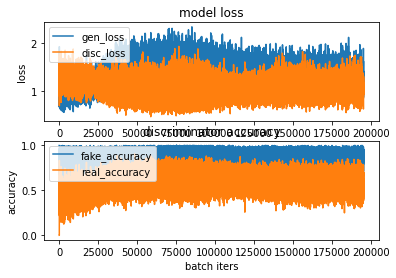

CPU times: user 2h 2min 51s, sys: 2min 27s, total: 2h 5min 18s
Wall time: 2h 3min 11s


In [84]:
%%time
train(train_dataset, EPOCHS, save_every)

### **07-4. 시각화**

In [85]:
anim_file = '/content/mydrive/MyDrive/AIFFEL/E14/re_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/mydrive/MyDrive/AIFFEL/E14/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [86]:
anim_file = '/content/mydrive/MyDrive/AIFFEL/E14/re_history.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/mydrive/MyDrive/AIFFEL/E14/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
